# 1. Importing libraries

In [1]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Machine learning imports
# -----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import *
from src.race_prediction_model.classification import *

# 2. Data loading

In [2]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [3]:
df.columns

Index(['DriverId', 'TeamId', 'Position', 'GridPosition', 'Time', 'Status',
       'Points', 'round', 'circuitId', 'Winner', 'Podium', 'MeanPreviousGrid',
       'MeanPreviousPosition', 'CurrentDriverWins', 'CurrentDriverPodiums'],
      dtype='object')

Since we want to predict whether a driver will win a race, we need to remove the columns that contain information about the race result, as we cannot provide input data about something that has not yet happened.

Our target variable in this case is `Winner` (it could be `Podium` if we want to predict if a driver will finish on the podium, `Position` if we want to predict the exact position, etc.).

Therefore, we can remove `Position`, `Time`, `Status`, `Points`, `Podium`. The rest of the variables can be known before the race takes place.

In [4]:
target = 'Podium'

drop = 'Winner' if target == 'Podium' else 'Podium'

df.drop(columns=['Position', 'Time', 'Status', 'Points', drop], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6433 entries, 8 to 11
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DriverId              6433 non-null   object 
 1   TeamId                6433 non-null   object 
 2   GridPosition          6433 non-null   float64
 3   round                 6433 non-null   int64  
 4   circuitId             6433 non-null   object 
 5   Podium                6433 non-null   int64  
 6   MeanPreviousGrid      6433 non-null   float64
 7   MeanPreviousPosition  6433 non-null   float64
 8   CurrentDriverWins     6433 non-null   int64  
 9   CurrentDriverPodiums  6433 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 552.8+ KB


We can explicitly check for null values

In [7]:
df.isna().sum()

DriverId                0
TeamId                  0
GridPosition            0
round                   0
circuitId               0
Podium                  0
MeanPreviousGrid        0
MeanPreviousPosition    0
CurrentDriverWins       0
CurrentDriverPodiums    0
dtype: int64

# 3. Preprocess

In [8]:
df.select_dtypes(include='O').columns

Index(['DriverId', 'TeamId', 'circuitId'], dtype='object')

### Encoding

We only need to encode the columns `DriverId`, `TeamId`, and `circuitId`.

* `DriverId`: We will apply target encoding since we want to give more weight to drivers with more victories.

* `TeamId`: We will use One Hot Encoding since the number of categories is small.

* `circuitId`: We will use ordinal encoding, as the circuits don't have any significance beyond the fact that some teams or drivers perform better than others.

### Scaling

Since we have very few outliers in our datasets and there are no extremely high values, we will use a `MinMax` scaler.

In [9]:
encoding_methods = {"onehot": ['TeamId'],
                    "target": ['DriverId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, target_variable=target)

# 4. Model selection

Estamos evaluendo un modelo que predice si un piloto ganará una carrera. En este caso queremos minimizar el número de errores en general, ya que es igual de malo predecir que un piloto va a ganar y equivocarnos que predecir que no lo va a hacer y sí lo haga.

Por lo tanto, trataremos mazimizar la métrica `f1_score` lo máximo posible ya que es un compromiso entre `precision`y `recall`.

In [10]:
models = ClassificationModels(df_scaled, target)

In [11]:
df_results = pd.DataFrame()

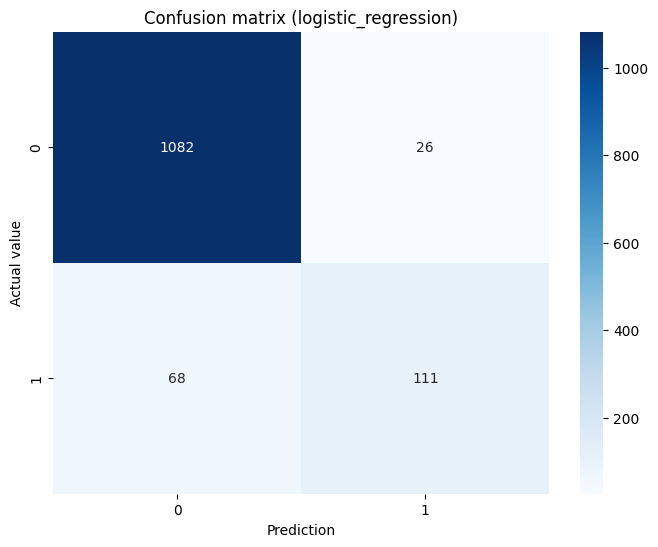

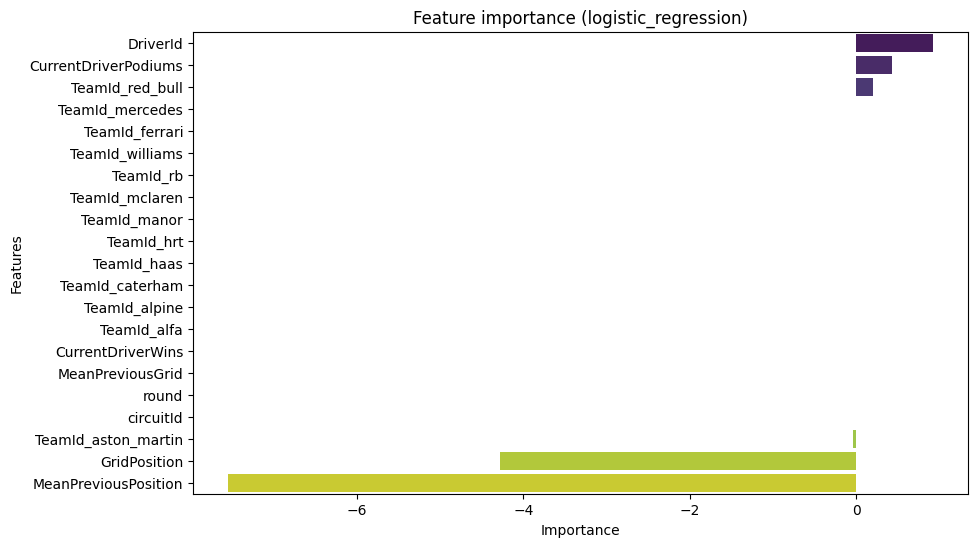

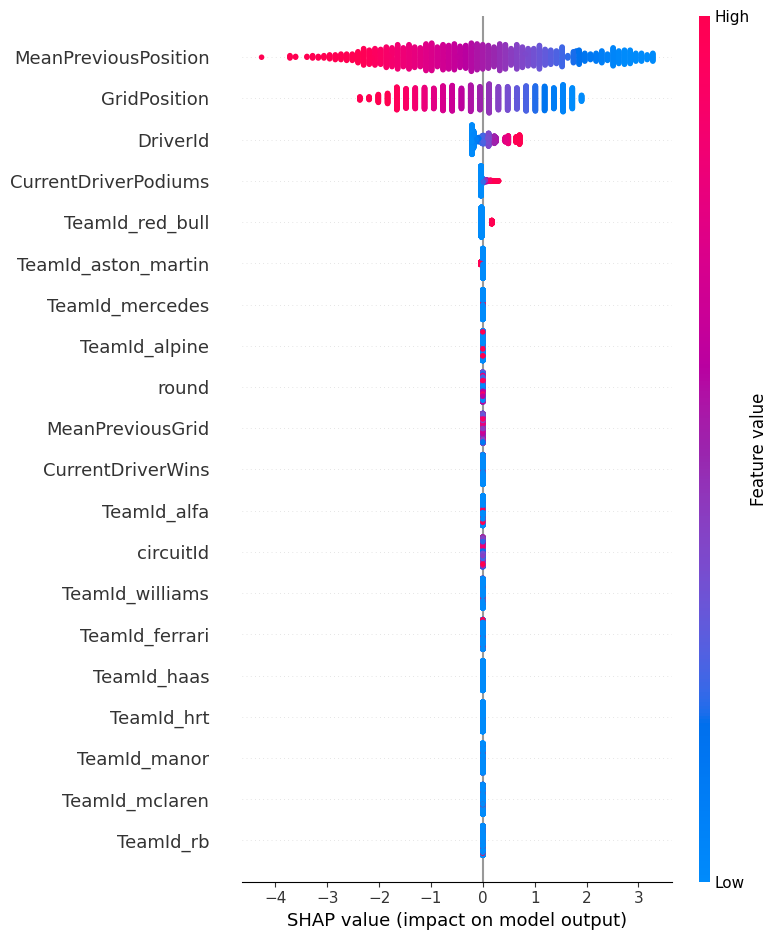

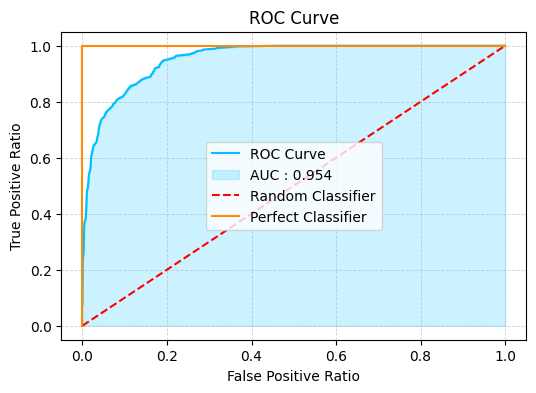

In [12]:
# model_list = ["logistic_regression", "tree", "random_forest", "gradient_boosting", "xgboost"]
model_list = ["logistic_regression"]

for model in model_list:

    models.fit_model(model, file_name=model)
    models.plot_confusion_matrix(model)
    models.plot_predictors_importance(model)
    models.plot_shap_summary(model)
    df_current_results = models.get_metrics(model)
    df_current_results["model"] = model
    df_results = pd.concat([df_results, df_current_results], axis=0)
    models.plot_roc_curve(model)

In [13]:
df_results

,accuracy,precision,recall,f1,kappa,auc,time_seconds,model
train,0.919938,0.915736,0.919938,0.916866,0.649173,0.952694,15.6131,logistic_regression
test,0.926962,0.922698,0.926962,0.922787,0.661738,0.954246,15.6131,logistic_regression


---

Next steps: Utilizar datos de los entrenamientos libres para enriquecer el modelo

In [14]:
model_name = model_list[0]

pred_train = models.results[model_name]["pred_train"]
pred_test = models.results[model_name]["pred_test"]

model = models.results[model_name]["best_model"]

metrics_train = {
    "accuracy": accuracy_score(models.y_train, pred_train),
    "precision": precision_score(models.y_train, pred_train),
    "recall": recall_score(models.y_train, pred_train),
    "f1": f1_score(models.y_train, pred_train)
    }

metrics_test = {
    "accuracy": accuracy_score(models.y_test, pred_test),
    "precision": precision_score(models.y_test, pred_test),
    "recall": recall_score(models.y_test, pred_test),
    "f1": f1_score(models.y_test, pred_test)
    }


In [15]:
metrics_test

{'accuracy': 0.9269619269619269,
 'precision': 0.8102189781021898,
 'recall': 0.6201117318435754,
 'f1': 0.7025316455696202}

In [16]:
pred_test = models.results[model_name]["pred_test"]

# Confusion matrix
matrix = confusion_matrix(models.y_test, pred_test)

In [17]:
matrix

array([[1082,   26],
       [  68,  111]])

---

In [23]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [24]:
threshold = 8

mask = (df['Position'] < threshold) | (df['GridPosition'] < threshold)

df = df[mask]

target = 'Podium'
drop = 'Winner' if target == 'Podium' else 'Podium'

df.drop(columns=['Position', 'Time', 'Status', 'Points', drop], inplace=True)

In [25]:
df.shape

(2772, 10)

In [26]:
# df.drop(columns=['round'], inplace=True)

In [27]:
encoding_methods = {"onehot": ['TeamId'],
                    "target": ['DriverId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, target_variable=target)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       372
           1       0.68      0.76      0.72       183

    accuracy                           0.80       555
   macro avg       0.78      0.79      0.78       555
weighted avg       0.81      0.80      0.81       555



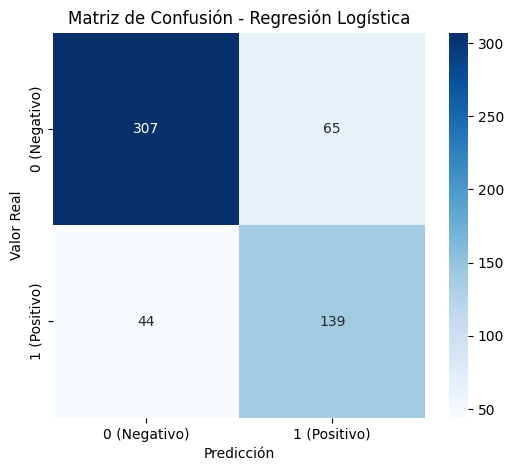

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar tus datos aquí si es necesario
df = df_encoded
X = df.drop(target, axis=1)  # Reemplaza "target" con el nombre de la columna objetivo
y = df[target]

# 2. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenar la Regresión Logística con ajuste de pesos para clases desbalanceadas
model = LogisticRegression(class_weight='balanced', random_state=42)
#model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Hacer predicciones
y_pred = model.predict(X_test_scaled)

# 6. Evaluación del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0 (Negativo)", "1 (Positivo)"], yticklabels=["0 (Negativo)", "1 (Positivo)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

In [29]:
metrics_test = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    }

metrics_test

{'accuracy': 0.8036036036036036,
 'precision': 0.6813725490196079,
 'recall': 0.7595628415300546,
 'f1': 0.7183462532299741}

In [30]:
importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": abs(model.coef_[0])
}).sort_values(by="Importance", ascending=False)

importances_df

,Feature,Importance
4,MeanPreviousPosition,6.238833
1,GridPosition,3.678974
6,CurrentDriverPodiums,1.068997
11,TeamId_haas,0.936479
0,DriverId,0.862571
8,TeamId_alpine,0.631008
7,TeamId_alfa,0.582388
17,TeamId_red_bull,0.531143
10,TeamId_ferrari,0.479010
2,round,0.448277
